# Clustering Molecules

💡 [Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) - the act of *grouping a set of objects in such a way that objects in the same group (called a **cluster**) are more similar (in some sense) to each other than to those in other groups (clusters).*

One of the largest challenges in early-stage drug discovery is narrowing down the massive chemical space of approximately **10 to the power of 60 molecules (10^60)** to a list of molecules that have the desired properties for a specific target of interest. This is where computational approaches comes in, taking a large library of small molecules and reduce its size by filtering in/out molecules based on similarity, patterns, predicted physicochemical properties, specific rules, etc. This selection process allows scientists to focus on compounds with the highest chance of success before experimental testing in a lab, saving time and money.

Clustering molecules is an extremely useful process where you can easily manipulate and subdivide large datasets to group compounds into smaller clusters with similar properties. Comparing molecules and their similarities can then be used to discover new molecules with optimal properties and desired biological activity. 

### How are compounds clustered?

Compounds can be clustered via multiple clustering algorithms. There are also multiple ways to measure similarity between compounds, and theoretically, any [molecular descriptor](https://pubs.acs.org/doi/abs/10.1021/jm401411z) can be used. ***The current common approach for structural clustering is the [Butina](https://pubs.acs.org/doi/abs/10.1021/ci9803381) algorithm which can use multiple similarity measures. In Datamol, the measure set as the default is the [Tanimoto similarity](http://www.biotech.fyicenter.com/1000134_What_Is_Tanimoto_coefficient.html#:~:text=Tanimoto%20coefficient%20is%20a%20metric,union%20of%20the%20two%20sets.) index, measured on a scale between 0 (not similar) to 1 (most similar)***. After clustering molecules, you can also identify **centroids**. These are essentially the molecules in the middle of the cluster and are frequently used to **represent** **the cluster as a whole**. 

For a more detailed breakdown of clustering methods and their uses in computational chemistry, read [here](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.94.630&rep=rep1&type=pdf).

**Note:** centroids are highlighted here only as an example. Centroid identification is not linked to clustering itself, and there are algorithms commonly utilized that have nothing to do with centroids (i.e. [hierarchical clustering](https://chemaxon.com/presentation/hierarchical-clustering-of-chemical-structures-by-maximum-common-substructures)).

## Molecular Fingerprints

In order for us to perform machine learning techniques or statistical analyses on molecules, we must represent molecules as mathematical objects (i.e vectors). Molecular fingerprints essentially encode the structural characteristics of molecules in the form of vectors enabling us to subsequently leverage statistical techniques to uncover new insights. 

The most common fingerprint used today is ECFP4 (extended connectivity fingerprints), also known as the Morgan fingerprint. [Here](https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1) is a practical blog that explains what and how to use ECFP4. 

## Tutorial

This tutorial will walk you through the following:

1. Loading an example dataset
2. Calculate fingerprints
3. Then generate distance matrix
4. Cluster with the Butina algorithm 
5. Pick diverse molecules from a list
    1. Why is this useful? 
        1. Resource limitations generally prevent you from experimentally testing as many compounds as you want/are available. Therefore, you want to be able to collect as much information as possible through diversity. By selecting diverse molecules (i.e. one representative example from each chemical series in a list), you can quickly gain information around the effect of structural changes on in vitro activity while exploring a larger chemical space in fewer “shots”.
6. Pick centroids from a set of molecules

First let’s see what this process would look like on RDKit: 

## RDKit Example

In [3]:
import operator

import datamol as dm
import numpy as np

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

### Clustering compounds

# Get some mols
data = dm.data.freesolv()
smiles = data["smiles"].iloc[:].tolist()
mols = [Chem.MolFromSmiles(s) for s in smiles]

# Create fingerprints
fps = [Chem.RDKFingerprint(x) for x in mols]

# Calculate distance matrix
dists = []
n_mols = len(mols)

for i in range(1, n_mols):
    dist = DataStructs.cDataStructs.BulkTanimotoSimilarity(fps[i], fps[:i], returnDistance=True)
    dists.extend([x for x in dist])

cutoff = 0.2

# now cluster the data
cluster_indices = Butina.ClusterData(dists, n_mols, cutoff, isDistData=True)
cluster_mols = [operator.itemgetter(*cluster)(mols) for cluster in cluster_indices]

# Make single mol cluster a list
cluster_mols = [[c] if isinstance(c, Chem.rdchem.Mol) else c for c in cluster_mols]

### Pick diverse compounds

# Get some mols
data = dm.data.freesolv()
smiles = data["smiles"].iloc[:].tolist()
mols = [Chem.MolFromSmiles(s) for s in smiles]

# Calculate fingerprints
fps = [Chem.RDKFingerprint(x) for x in mols]


def distij(i, j, features=fps):
    return 1.0 - DataStructs.cDataStructs.TanimotoSimilarity(fps[i], fps[j])


npick = 10
seed = 0

picker = MaxMinPicker()
initial_picks = []
picked_inds = picker.LazyPick(distij, len(mols), npick, firstPicks=initial_picks, seed=seed)
picked_inds = np.array(picked_inds)
picked_mols = [mols[x] for x in picked_inds]

picked_inds, picked_mols

(array([352,   2,  10,  56,  61,  85,  92, 176, 262, 408]),
  <rdkit.Chem.rdchem.Mol at 0x7f5377214ee0>])

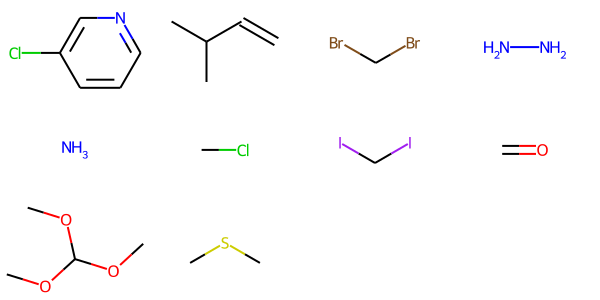

In [12]:
dm.to_image(picked_mols, mol_size=(150, 100))

## Datamol Example

**Note:** Datamol abstracts away the explicit steps 2 (calculating fingerprints) and 3 (generating a distance matrix) of the tutorial

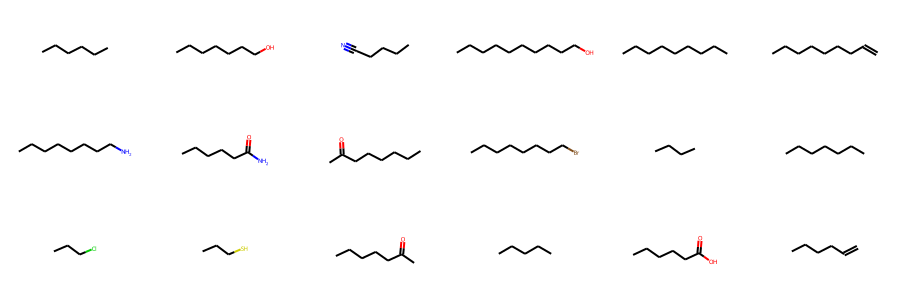

In [8]:
import datamol as dm

# Load example dataset
data = dm.data.freesolv()
smiles = data["smiles"].iloc[:].tolist()
mols = [dm.to_mol(s) for s in smiles]

# Cluster the mols
clusters, mol_clusters = dm.cluster_mols(mols, cutoff=0.7)

# Cluster #1
dm.to_image(mol_clusters[0], mol_size=(150, 100), n_cols=6, max_mols=18)

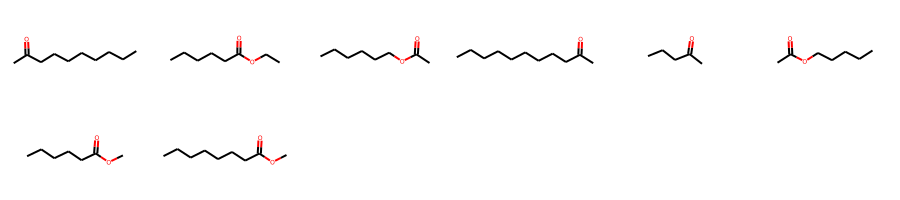

In [10]:
# Cluster #2
dm.to_image(mol_clusters[1], mol_size=(150, 100), n_cols=6, max_mols=18)

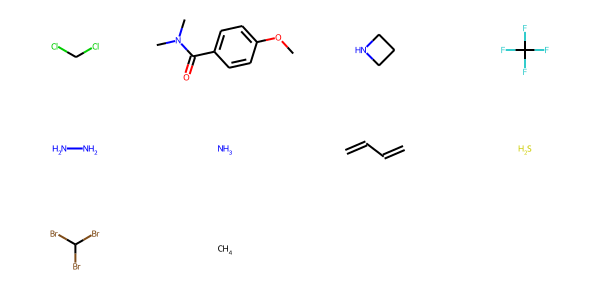

In [14]:
# Pick a diverse set of molecules
indices, picks = dm.pick_diverse(mols, npick=10)
dm.to_image(picks, mol_size=(150, 100))

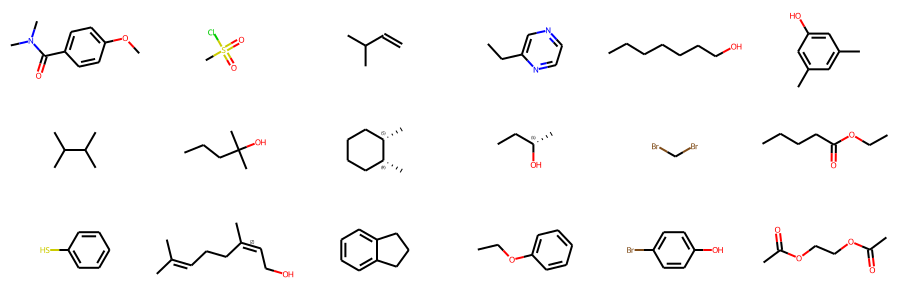

In [16]:
# Pick centroids from a set of molecules
indices, centroids = dm.pick_centroids(mols, npick=18, threshold=0.7, method="sphere", n_jobs=-1)
dm.to_image(centroids, mol_size=(150, 100), n_cols=6)

**Note**: Datamol provides one method (Butina using Tanimoto/ECFP for distances computations) for clustering molecules. In practice, an infinite number of methods exists and the user should build them as needed. Please feel free to contribute to Datamol if you wish to add any specific methods that are useful! 

## Understanding key parameters

- Determining an appropriate threshold for cutoff
    - Butina uses distances (which is 1 - distance) and the cutoff is dependent on the distance metric used. As mentioned earlier, Datamol uses Tanimoto with ECFP fingerprint. Therefore the distance cutoff is 1 - Tanimoto.
    - Generally speaking, if you have a very small distance cutoff, compounds must be extremely similar (i.e. high Tanimoto score) in order to be grouped into one cluster. Therefore, with a small distance cutoff, you’ll get more clusters with fewer compounds per cluster. Vice versa is true.

**Note:** This is an extremely general overview, in reality, the output greatly depends on both the size and diversity of the dataset being used. There is no “default” cutoff that is set in Datamol and instead each user should set cutoffs according to their specific dataset and use case. 

You can also see a more detailed definition of the methods, arguments and their returns, [here](https://github.com/datamol-org/datamol/blob/main/datamol/cluster.py#L173). 

## References

- Macs in Chemistry - [https://www.macinchem.org/reviews/clustering/clustering.php](https://www.macinchem.org/reviews/clustering/clustering.php)
- TeachOpenCADD - [https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html#Picking-diverse-compounds](https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html#Picking-diverse-compounds)
- [https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00445-4](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00445-4)
- [https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1](https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1)